# Data Wrangling : We `RateDogs` Twitter Data

## Importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn
import re


## Gather Data

### Twitter archive

In [2]:
# Reading CSV file
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

### Image prediction

In [3]:
# Downloading URL
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(url)

with open ('image-predictions.tsv',mode='wb') as file:
    file.write(r.content)
    
# Reading TSV file 
df_img_prediction = pd.read_csv('image-predictions.tsv',sep='\t')


### Twitter API & JSON

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

# function to get the data from twitter api
def get_twitter_data(df, file_path):
    """
    get_twitter_data: function to get twitter data using tweepy library
    to access twitter API.
    ARGS:
        df: a pandas data frame which stores the tweets ids in tweet_id column.
        file_path: a file path for the file to save the retrived data in.
    Return: nothing
    """
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Tweet IDs for which to gather additional data via Twitter's API
    tweet_ids = df.tweet_id.values
    len(tweet_ids)

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open(file_path, 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

In [5]:
# Download data from twitter API 
if not os.path.exists('tweet-json.txt'):
    get_twitter_data(df_archive, 'tweet-json.txt')

In [6]:
# Load tweets data into pandas df
with open('tweet-json.txt') as file:
    df_api = pd.read_json(file, lines= True, encoding = 'utf-8')
    


## Assess Data

### Inspecting the dataset for two things :
- Data quality issues 
- Tidiness issues 

### Twitter archive

#### Visual assessment

In [7]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


#### Programmatic assessment

In [8]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
sum(df_archive.duplicated())

0

In [11]:
df_archive['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [12]:
df_archive['source'][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [13]:
df_archive[[ 'doggo', 'floofer', 'pupper', 'puppo']]

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None
...,...,...,...,...
2351,None,None,None,None
2352,None,None,None,None
2353,None,None,None,None
2354,None,None,None,None


In [14]:
df_archive['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
           ... 
Philippe      1
Hamrick       1
Ace           1
Trigger       1
Marlee        1
Name: name, Length: 957, dtype: int64

In [15]:
df_archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [16]:
df_archive[df_archive['name'].str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


In [17]:
df_archive[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [18]:
df_archive[df_archive['rating_numerator'] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,666826780179869698,NaN,NaN,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666826780...,12,10,None,None,None,None,None
2324,666421158376562688,NaN,NaN,2015-11-17 01:02:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*internally screaming* 12/10 https://t.co/YMcr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666421158...,12,10,None,None,None,None,None
2329,666373753744588802,NaN,NaN,2015-11-16 21:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Those are sunglasses and a jean jacket. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666373753...,11,10,None,None,None,None,None
2336,666273097616637952,NaN,NaN,2015-11-16 15:14:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Can take selfies 11/10 https://t.co/ws2AMaNwPW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666273097...,11,10,None,None,None,None,None


In [19]:
df_archive[df_archive['rating_denominator'] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


### Image prediction

#### Visual assessment

In [20]:
df_img_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### Programmatic assessment

In [21]:
df_img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_img_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
# Checking for duplicate 
sum(df_img_prediction.duplicated())

0

In [24]:
df_img_prediction['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [25]:
df_img_prediction['p1'].unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama',
       'Chesapeake_Bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'Ibizan_hound', 'Border_collie', 'Labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'Airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 't

In [26]:
df_img_prediction['p2'].unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'Rottweiler', 'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'Irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'Weimaraner', 'slug', 'Brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'African_hunting_dog', 'vizsla', 'doormat',
       'pug', 'Italian_greyhound', 'Samoyed', 'Pomeranian',
       'miniature_poodle', 'Lakeland_terrier', 'Irish_setter', 'swab',
       'malamute', 'bath_towel', 'Border_collie', 'Leonberg', 'drake',
       'French_bulldog', 'ice_bear', 

In [27]:
df_img_prediction['p3'].unique()

array(['Shetland_sheepdog', 'Rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'Doberman', 'Greater_Swiss_Mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'Labrador_retriever', 'Pekinese',
       'Ibizan_hound', 'French_bulldog', 'malinois', 'Dandie_Dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'Eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'Chihuahua',
       'Shih-Tzu', 'Pomeranian', 'dingo', 'power_drill', 'Saluki',
       'Great_Pyrenees', 'West_Highland_white_terrier', 'collie',
       'toy_poodle', 'vizsla', 'acorn', 'giant_schnauzer', 'teddy',
       'common_iguana', 'wig', 'water_buffalo', 'coyote', 'seat_belt',
       'kelpie', 'space_heater', 'Brabancon_griffon', 'standard_poodle',
       'beagle', 'Irish_water_spaniel', 'bluetick', 'Weimaraner',
       'Chesapeake_Bay_retriever', 'toilet_tiss

In [28]:
df_img_prediction[['p1_conf','p2_conf','p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


In [29]:
df_img_prediction.loc[(df_img_prediction['p1_dog'] == False) & 
                        (df_img_prediction['p2_dog'] == False) &
                        (df_img_prediction['p3_dog'] == False)
                       ]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


### API file

#### Visual assessment

In [30]:
df_api

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2350,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2351,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2352,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


#### Programmatic assessment

In [31]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [32]:
df_api.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,0.0,0.0,0.0,2354.000000,2354.000000,2211.0,2211.0,2.900000e+01,2.900000e+01
mean,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,NaN,NaN,NaN,3164.797366,8080.968564,0.0,0.0,8.162686e+17,8.162686e+17
std,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,NaN,NaN,NaN,5284.770364,11814.771334,0.0,0.0,6.164161e+16,6.164161e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,NaN,NaN,NaN,624.500000,1415.000000,0.0,0.0,7.888183e+17,7.888183e+17
50%,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1473.500000,3603.500000,0.0,0.0,8.340867e+17,8.340867e+17
75%,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3652.000000,10122.250000,0.0,0.0,8.664587e+17,8.664587e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,79515.000000,132810.000000,0.0,0.0,8.860534e+17,8.860534e+17


### Observation 

#### Quality 
- `source` column is  we can extract the source of the tweet and covert it to categorical.
- `text` column has `the link for the tweets` and `ratings` at the end we can remove it.
- Columns `(doggo, floofer, pupper, puppo)` has None for missing values.
- `name` column have None instead of NaN and too many unvalid values.
- `timestamp` column is str instead of datetime
- We are interested in the `tweet ONLY` not the `retweet` there for we should remove those from the table.
- We are interested in the `tweet ONLY` not the `reply to the original tweet` there for we should remove those from the table.
- `rating_denominator` column has values less than 10 and values more than 10 for ratings more than one dog.
- Column `expanded_urls` has missing values are for tweets without photo

#### Tidiness
- `doggo`, `floofer`, `pupper`, `puppo` columns are all about the same things, `dog stage`.
- Column `img_num` useless
- Columns `(p1,p2,p3)` combine them in column `doy_type` and Columns `(p1_conf,p2_conf,p3_conf)` combine them in column `p_confidence`
- Just 3 columns needed `id`, `retweet_count`, `favorite_count`
- Combine all dataset in `df_data`



## Clean Data

### Take a copy from our data to work on  cleaning it

In [33]:
df_archive_clean = df_archive.copy()
df_img_prediction_clean = df_img_prediction.copy()
df_api_clean = df_api.copy()

### Quality Issues 

#### Define

Extract the source of the tweet fron `source` column and covert by using `apply` method.

#### Code

In [34]:
df_archive_clean['source'][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [35]:
def fix_source(x):
    i = x.find('>')+1
    j = x[i:].find('<')
    return x[i:][:j]

In [36]:
df_archive_clean['source']= df_archive_clean['source'].apply(lambda x : fix_source(x))

#### Test

In [37]:
df_archive_clean['source'].sample(10)

403      Twitter for iPhone
504      Twitter for iPhone
1326    Vine - Make a Scene
127      Twitter for iPhone
41       Twitter for iPhone
1783     Twitter for iPhone
2138     Twitter for iPhone
1484     Twitter for iPhone
444      Twitter Web Client
2305     Twitter for iPhone
Name: source, dtype: object

#### Define

Remove `Link of tweets` and `Rating` from `text` column   

#### Code

In [38]:
df_archive_clean.text

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
                              ...                        
2351    Here we have a 1949 1st generation vulpix. Enj...
2352    This is a purebred Piers Morgan. Loves to Netf...
2353    Here is a very happy pup. Big fan of well-main...
2354    This is a western brown Mitsubishi terrier. Up...
2355    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 2356, dtype: object

In [39]:
df_archive_clean.text = df_archive_clean.text.str.extract('(.+(?=\s\d+/\d+\s))')


#### Test

In [40]:
df_archive_clean.text.sample(5)

1205         This is Bubbles. He's a Yorkshire Piccolope.
163     This is Jordy. He likes to go on adventures an...
951                 This is Lola. She's a surfing pupper.
1876    Say hello to Oliver. He thought what was insid...
184                                                   NaN
Name: text, dtype: object

#### Define

Remove `None` for columns `(doggo, floofer, pupper, puppo)` 

#### Code

In [41]:
for col in ['doggo', 'floofer', 'pupper', 'puppo']:
    df_archive_clean[col] = df_archive_clean[col].replace('None',np.nan)

#### Test

In [42]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2234 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       97 no

#### Define

* Replace 'None' with np.name in df_archive `name` column.
* Remove any rows with invalid names which starts with lower laters.

#### Code

In [43]:
df_archive_clean[~df_archive_clean.name.str.istitle()].name.unique()


array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'BeBe', 'mad',
       'an', 'very', 'just', 'DonDon', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'CeCe', 'the',
       'by', 'officially', 'life', 'light', 'space', 'JD', 'DayZ'],
      dtype=object)

In [44]:
df_archive_clean.name.replace(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad',
       'an', 'very', 'just', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'the',
       'by', 'officially', 'life', 'light', 'space', 'None'],np.nan,inplace=True)

#### Test

In [45]:
df_archive_clean.name.value_counts()

Charlie     12
Oliver      11
Cooper      11
Lucy        11
Lola        10
            ..
Philippe     1
Hamrick      1
Ace          1
Trigger      1
Jessiga      1
Name: name, Length: 931, dtype: int64

In [46]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2234 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1502 non-null   object 
 13  doggo                       97 no

#### Define

Convert `timestamp` column to datetime

#### Code

In [47]:
df_archive_clean.timestamp = pd.to_datetime(df_archive_clean['timestamp'])

#### Test

In [48]:
df_archive_clean.timestamp.dtype

datetime64[ns, UTC]

#### Define

Delete `retweet` and `reply to the original tweet`

#### Code

In [49]:
df_archive_clean = df_archive_clean.query('in_reply_to_status_id == "NaN" &\
                                                     in_reply_to_user_id == "NaN" &\
                                                    retweeted_status_id == "NaN" &\
                                                    retweeted_status_user_id == "NaN"')
# drop columns
cols = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id', 'retweeted_status_timestamp']
df_archive_clean.drop(columns = cols, axis=1, inplace=True)

#### Test

In [50]:
df_archive_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2029 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                1390 non-null   object             
 8   doggo               83 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              230 non-null    object             
 11  puppo               24 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(3

#### Define

Remove values not equal 10 in `rating_denominator`

#### Code

In [51]:
df_archive_clean[df_archive_clean['rating_denominator'] != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40+00:00,Twitter for iPhone,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,NaN,NaN,NaN,NaN
516,810984652412424192,2016-12-19 23:06:23+00:00,Twitter for iPhone,Meet Sam. She smiles,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,NaN,NaN,NaN,NaN
902,758467244762497024,2016-07-28 01:00:57+00:00,Twitter for iPhone,Why does this never happen at my front door...,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,NaN,NaN,NaN,NaN
1068,740373189193256964,2016-06-08 02:41:38+00:00,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,NaN,NaN,NaN,NaN
1120,731156023742988288,2016-05-13 16:15:54+00:00,Twitter for iPhone,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,NaN,NaN,NaN,NaN,NaN
1165,722974582966214656,2016-04-21 02:25:47+00:00,Twitter for iPhone,Happy 4/20 from the squad!,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,NaN,NaN,NaN,NaN
1202,716439118184652801,2016-04-03 01:36:11+00:00,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,NaN,NaN,NaN,NaN
1228,713900603437621249,2016-03-27 01:29:02+00:00,Twitter for iPhone,Happy Saturday here's 9 puppers on a bench.,https://twitter.com/dog_rates/status/713900603...,99,90,NaN,NaN,NaN,NaN,NaN
1254,710658690886586372,2016-03-18 02:46:49+00:00,Twitter for iPhone,Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,NaN,NaN,NaN,NaN,NaN
1274,709198395643068416,2016-03-14 02:04:08+00:00,Twitter for iPhone,None know where camera is.,https://twitter.com/dog_rates/status/709198395...,45,50,NaN,NaN,NaN,NaN,NaN


In [52]:
df_archive_clean = df_archive_clean[df_archive_clean['rating_denominator'] == 10] 

#### Test

In [53]:
df_archive_clean[df_archive_clean['rating_denominator'] != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define

Remove non values in `expanded_urls` column

#### Code

In [54]:
df_archive_clean = df_archive_clean.loc[~df_archive_clean['expanded_urls'].isnull()]


#### Test

In [55]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2077 non-null   int64              
 1   timestamp           2077 non-null   datetime64[ns, UTC]
 2   source              2077 non-null   object             
 3   text                2010 non-null   object             
 4   expanded_urls       2077 non-null   object             
 5   rating_numerator    2077 non-null   int64              
 6   rating_denominator  2077 non-null   int64              
 7   name                1387 non-null   object             
 8   doggo               83 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              229 non-null    object             
 11  puppo               24 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(3

### Tidiness Issues

#### Define

Columns `(doggo , floofer , pupper , puppo )` are same thing >> `dog_stage` combine them in `dog_stage` column

#### Code

In [56]:
def dog_stage(x):
    lst = []
    if x['doggo'] == 'doggo':
        lst.append('doggo')
    if x['floofer'] == 'floofer':
        lst.append('floofer')
    if x['pupper'] == 'pupper':
        lst.append('pupper')
    if x['puppo'] == 'puppo':
        lst.append('puppo')
    
    if not lst:
        return "None"
    else:
        return ','.join(lst)
    
df_archive_clean['dog_stage'] = df_archive_clean.apply(lambda x: dog_stage(x), axis=1)

df_archive_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)
df_archive_clean.replace('None',np.nan,inplace=True)

#### Test

In [57]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2077 non-null   int64              
 1   timestamp           2077 non-null   datetime64[ns, UTC]
 2   source              2077 non-null   object             
 3   text                2010 non-null   object             
 4   expanded_urls       2077 non-null   object             
 5   rating_numerator    2077 non-null   int64              
 6   rating_denominator  2077 non-null   int64              
 7   name                1387 non-null   object             
 8   dog_stage           335 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 162.3+ KB


In [58]:
df_archive_clean.dog_stage.value_counts()

pupper           220
doggo             72
puppo             23
doggo,pupper       9
floofer            9
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

#### Define

Remove column `img_num`

#### Code

In [59]:
df_img_prediction_clean.drop('img_num',axis=1,inplace=True)

#### Test

In [60]:
df_img_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   p1        2075 non-null   object 
 3   p1_conf   2075 non-null   float64
 4   p1_dog    2075 non-null   bool   
 5   p2        2075 non-null   object 
 6   p2_conf   2075 non-null   float64
 7   p2_dog    2075 non-null   bool   
 8   p3        2075 non-null   object 
 9   p3_conf   2075 non-null   float64
 10  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.9+ KB


#### Define
- Create 1 column for image prediction and 1 column for confidence
- Delete columns (p1,p2,p3) + (p1_conf,p2_conf,p3_conf)

#### Code

In [61]:
dog_type = []
p_confidence = []

def image(df_img_prediction_clean):
    if df_img_prediction_clean['p1_dog'] == True:
        dog_type.append(df_img_prediction_clean['p1'])
        p_confidence.append(df_img_prediction_clean['p1_conf'])
    elif df_img_prediction_clean['p2_dog'] == True:
        dog_type.append(df_img_prediction_clean['p2'])
        p_confidence.append(df_img_prediction_clean['p2_conf'])
    elif df_img_prediction_clean['p3_dog'] == True:
        dog_type.append(df_img_prediction_clean['p3'])
        p_confidence.append(df_img_prediction_clean['p3_conf'])
    else:
        dog_type.append('Error')
        p_confidence.append('Error')
        
df_img_prediction_clean.apply(image,axis=1)

df_img_prediction_clean['dog_type'] = dog_type
df_img_prediction_clean['p_confidence'] = p_confidence
    

In [62]:
df_img_prediction_clean = df_img_prediction_clean[df_img_prediction_clean['dog_type'] != 'Error']

In [63]:
df_img_prediction_clean = df_img_prediction_clean.drop([ 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#### Test

In [64]:
df_img_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_id      1751 non-null   int64 
 1   jpg_url       1751 non-null   object
 2   dog_type      1751 non-null   object
 3   p_confidence  1751 non-null   object
dtypes: int64(1), object(3)
memory usage: 68.4+ KB


#### Define

Remove unnecessary columns in `df_api`

#### Code

In [65]:
df_api_clean = df_api[['id', 'retweet_count', 'favorite_count']]

#### Test

In [66]:
df_api_clean

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [67]:
df_api_clean.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


#### Define

combine all dataset in `df_data` by using `merge` method

#### Code

In [68]:
df_api_clean.rename(columns={'id':'tweet_id'},inplace=True)

C:\Users\Amrelbalshy\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [69]:
df_data = pd.merge(df_archive_clean,df_img_prediction_clean,on='tweet_id')
df_data = pd.merge(df_data,df_api_clean,on='tweet_id')

#### Test

In [70]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 0 to 1649
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1650 non-null   int64              
 1   timestamp           1650 non-null   datetime64[ns, UTC]
 2   source              1650 non-null   object             
 3   text                1592 non-null   object             
 4   expanded_urls       1650 non-null   object             
 5   rating_numerator    1650 non-null   int64              
 6   rating_denominator  1650 non-null   int64              
 7   name                1183 non-null   object             
 8   dog_stage           257 non-null    object             
 9   jpg_url             1650 non-null   object             
 10  dog_type            1650 non-null   object             
 11  p_confidence        1650 non-null   object             
 12  retweet_count       1650 non-null 

In [71]:
df_data

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,dog_type,p_confidence,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,666049248165822465,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,41,111
1646,666044226329800704,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,147,311
1647,666033412701032449,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,47,128
1648,666029285002620928,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,48,132


In [72]:
df_data['rating'] = df_data['rating_numerator'] / df_data['rating_denominator']

In [73]:
df_data.rename(columns={'rating_numerator':'numerator','rating_denominator':'denominator'},inplace=True)

In [74]:
df_data

,tweet_id,timestamp,source,text,expanded_urls,numerator,denominator,name,dog_stage,jpg_url,dog_type,p_confidence,retweet_count,favorite_count,rating
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819,1.3
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461,1.2
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908,1.3
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048,1.2
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,666049248165822465,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,41,111,0.5
1646,666044226329800704,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,147,311,0.6
1647,666033412701032449,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,47,128,0.9
1648,666029285002620928,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,48,132,0.7


## Store Data

In [75]:
df_data.to_csv('twitter_archive_master.csv',index = False)

In [76]:
df = pd.read_csv('twitter_archive_master.csv')
df

,tweet_id,timestamp,source,text,expanded_urls,numerator,denominator,name,dog_stage,jpg_url,dog_type,p_confidence,retweet_count,favorite_count,rating
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819,1.3
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461,1.2
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908,1.3
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048,1.2
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,666049248165822465,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,41,111,0.5
1646,666044226329800704,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,147,311,0.6
1647,666033412701032449,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,47,128,0.9
1648,666029285002620928,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,48,132,0.7


## Analysis and  Visualize Data

### First insight 


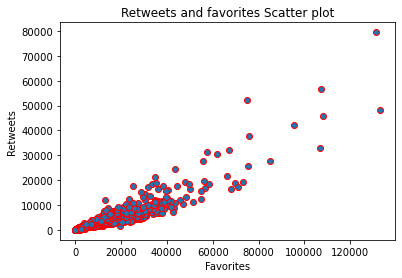

In [77]:
plt.scatter(df['favorite_count'], df['retweet_count'],edgecolors='red')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')
plt.savefig('retweet_favorite.png');

In [78]:
count_dogs = df.groupby('dog_stage')['tweet_id'].count()
count_dogs

dog_stage
doggo             54
doggo,floofer      1
doggo,pupper       7
doggo,puppo        1
floofer            7
pupper           166
puppo             21
Name: tweet_id, dtype: int64

In [79]:
df.name.value_counts().nlargest(10)

Cooper     10
Charlie    10
Lucy       10
Oliver      9
Tucker      9
Penny       8
Daisy       7
Winston     7
Sadie       7
Jax         6
Name: name, dtype: int64

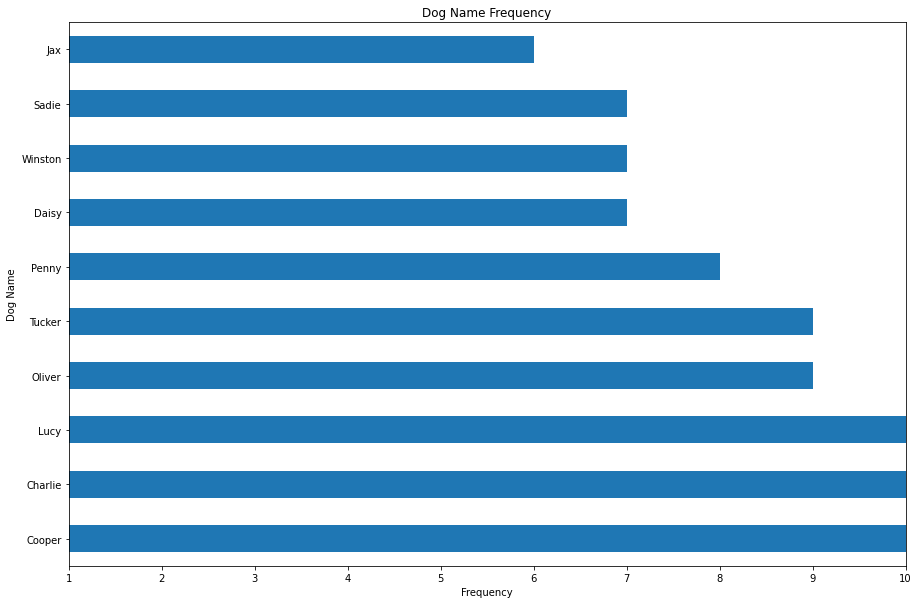

In [80]:
plt.subplots(figsize=(15, 10))
df.name.value_counts().nlargest(10).plot(kind = 'barh');
plt.title('Dog Name Frequency');
plt.xlabel('Frequency');
plt.ylabel('Dog Name');
plt.xlim(1, 10);
plt.savefig('dog_name.png');

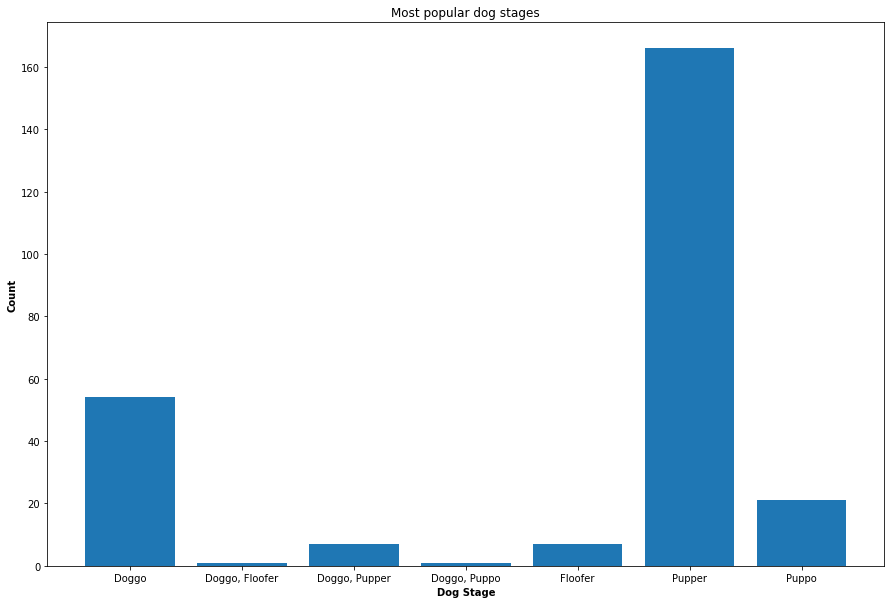

In [81]:
plt.subplots(figsize=(15, 10))
plt.bar([1, 2, 3, 4, 5, 6, 7], count_dogs, tick_label=['Doggo', 'Doggo, Floofer', 'Doggo, Pupper', 'Doggo, Puppo', 
                                                       'Floofer','Pupper', 'Puppo'])
plt.title('Most popular dog stages')
plt.xlabel('Dog Stage', weight='bold')
plt.ylabel('Count', weight='bold')
plt.savefig('most_pop_types.png');

### Second insight
* Most dog in the datset is `golden_retriever`

In [82]:
df['dog_type'].value_counts()

golden_retriever        153
Labrador_retriever      103
Pembroke                 94
Chihuahua                89
pug                      62
                       ... 
clumber                   1
silky_terrier             1
standard_schnauzer        1
Bouvier_des_Flandres      1
Irish_wolfhound           1
Name: dog_type, Length: 113, dtype: int64

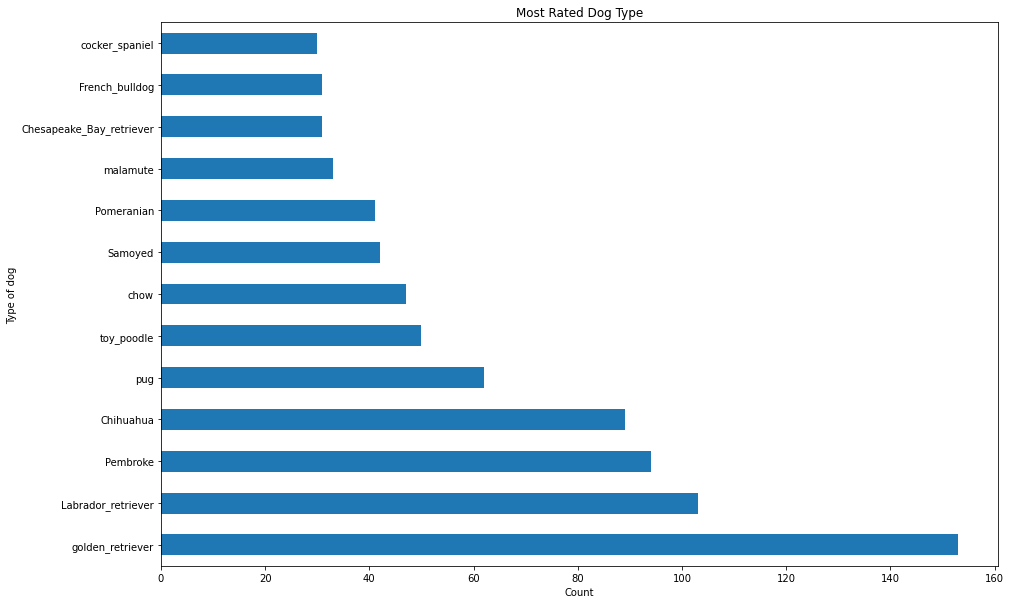

In [83]:
df_dog_type = df.groupby('dog_type').filter(lambda x: len(x) >= 25)
plt.subplots(figsize=(15, 10))
df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

### Third insight

In [84]:
df_dog_type_count = df.groupby('dog_type').count()
df_dog_type_count

,tweet_id,timestamp,source,text,expanded_urls,numerator,denominator,name,dog_stage,jpg_url,p_confidence,retweet_count,favorite_count,rating
dog_type,,,,,,,,,,,,,,
Afghan_hound,3,3,3,3,3,3,3,3,0,3,3,3,3,3
Airedale,12,12,12,12,12,12,12,9,1,12,12,12,12,12
American_Staffordshire_terrier,16,16,16,16,16,16,16,11,3,16,16,16,16,16
Appenzeller,2,2,2,2,2,2,2,1,0,2,2,2,2,2
Australian_terrier,2,2,2,2,2,2,2,2,0,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toy_poodle,50,50,50,49,50,50,50,39,8,50,50,50,50,50
toy_terrier,3,3,3,3,3,3,3,2,0,3,3,3,3,3
vizsla,13,13,13,12,13,13,13,10,1,13,13,13,13,13


In [85]:
df_dog_type_mean = df.groupby('dog_type').mean()
df_dog_type_mean

,tweet_id,numerator,denominator,p_confidence,retweet_count,favorite_count,rating
dog_type,,,,,,,
Afghan_hound,8.041621e+17,9.666667,10.0,0.433959,5976.000000,17326.666667,0.966667
Airedale,7.184489e+17,9.833333,10.0,0.583771,1393.750000,5280.833333,0.983333
American_Staffordshire_terrier,7.597284e+17,10.312500,10.0,0.527359,2310.812500,9380.187500,1.031250
Appenzeller,7.939334e+17,11.000000,10.0,0.503665,1458.000000,7317.500000,1.100000
Australian_terrier,7.785921e+17,11.500000,10.0,0.307584,3078.500000,11127.500000,1.150000
...,...,...,...,...,...,...,...
toy_poodle,7.216408e+17,11.000000,10.0,0.466878,2306.600000,6745.400000,1.100000
toy_terrier,7.166375e+17,10.333333,10.0,0.321651,834.333333,3181.666667,1.033333
vizsla,7.474321e+17,10.846154,10.0,0.661060,1992.846154,7492.461538,1.084615


In [86]:
dog_type_count = df_dog_type_count['rating']
dog_type_count

dog_type
Afghan_hound                       3
Airedale                          12
American_Staffordshire_terrier    16
Appenzeller                        2
Australian_terrier                 2
                                  ..
toy_poodle                        50
toy_terrier                        3
vizsla                            13
whippet                           11
wire-haired_fox_terrier            2
Name: rating, Length: 113, dtype: int64

In [87]:
dog_type_mean = df_dog_type_mean['rating']
dog_type_mean

dog_type
Afghan_hound                      0.966667
Airedale                          0.983333
American_Staffordshire_terrier    1.031250
Appenzeller                       1.100000
Australian_terrier                1.150000
                                    ...   
toy_poodle                        1.100000
toy_terrier                       1.033333
vizsla                            1.084615
whippet                           1.018182
wire-haired_fox_terrier           1.150000
Name: rating, Length: 113, dtype: float64

In [88]:
df = pd.DataFrame()
df['dog_type_count'] = dog_type_count
df['dog_type_mean'] = dog_type_mean
df

,dog_type_count,dog_type_mean
dog_type,,
Afghan_hound,3,0.966667
Airedale,12,0.983333
American_Staffordshire_terrier,16,1.031250
Appenzeller,2,1.100000
Australian_terrier,2,1.150000
...,...,...
toy_poodle,50,1.100000
toy_terrier,3,1.033333
vizsla,13,1.084615


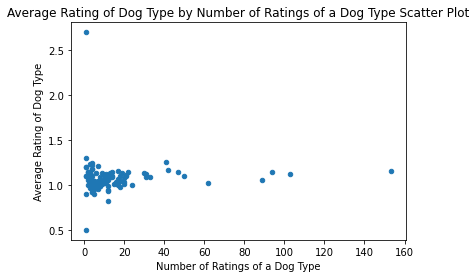

In [89]:
df.plot(x='dog_type_count', y='dog_type_mean', kind='scatter')
plt.xlabel('Number of Ratings of a Dog Type')
plt.ylabel('Average Rating of Dog Type')
plt.title('Average Rating of Dog Type by Number of Ratings of a Dog Type Scatter Plot')

fig = plt.gcf()
#plt.savefig('X:/' + newName + '.png', 
fig.savefig('output2.png',bbox_inches='tight');